In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics


import geopy
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

from vincenty import vincenty

import warnings

### a) Predict the journey duration. You may use any Start information in the data set. Also consider creating new features that may help prediction quality (Hint: In the coding week, we discussed creating polynomial features. How would you engineer features for periodic quantities with known period lengths, e.g, a day, a year, …?).

In [2]:
data = pd.read_csv("../data/processed/dortmund_trips.csv", index_col = 0)

In [3]:
data.head()

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,distance,weekday,weekend,day,month,hour
0,2019-01-20 16:22:00,50641,51.506312,Hainallee / Südbad,7.470531,2019-01-20 17:00:00,51.493966,TU Dortmund Emil-Figge-Straße 50,7.418008,38,3.897290,6,True,20,1,16
1,2019-01-20 02:31:00,50425,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 02:43:00,51.513069,Unionstr.,7.448886,12,0.891383,6,True,20,1,2
2,2019-01-20 11:32:00,53006,51.509557,Ritterhausstr.,7.446949,2019-01-20 13:33:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,121,1.235649,6,True,20,1,11
3,2019-01-20 14:38:00,53006,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 14:53:00,51.500725,Polizeipräsidium,7.459819,15,1.827997,6,True,20,1,14
4,2019-01-20 17:02:00,53006,51.500725,Polizeipräsidium,7.459819,2019-01-20 17:16:00,51.514029,Schwanenwall,7.472570,14,1.724677,6,True,20,1,17


Get the outliers in trip duration

Text(0.5, 0, 'trip duration in minutes')

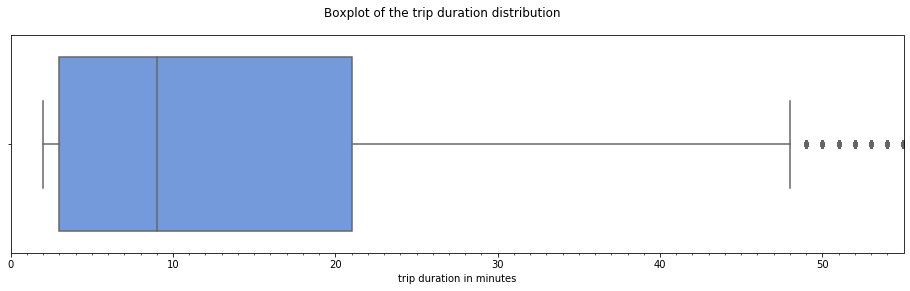

In [4]:
#identifiy outlier record based on trip duration
ax = plt.figure(figsize = (16,4))
ax.suptitle("Boxplot of the trip duration distribution", y=0.98)
ax = sns.boxplot (x=data["trip_duration"], color='cornflowerblue')
ax.set_xticks(np.arange(0, 55),1)
ax.set_xlim([0, 55]) 
ax.set_xlabel('trip duration in minutes')

trips shorter than 2min and longer than 48min are outliers

In [6]:
trips_without_outliers = data[(data["trip_duration"]>= 2) & (data["trip_duration"]<= 48)]

In [7]:
amount_deleted_rows = len(data) - len(trips_without_outliers)
print(amount_deleted_rows, "of", len(data) ,"rows were deleted due outlier-handling")
print("This equals", amount_deleted_rows/len(data) * 100, "%")

27599 of 207476 rows were deleted due outlier-handling
This equals 13.302261466386472 %


In [8]:
# this is our y
duration = data["trip_duration"]

# this is our x
data = data.drop(columns=["trip_duration", "datetime_start", "p_name_start", "b_number_start", "datetime_end", "p_name_end"], axis = 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, duration, test_size = 0.3)

In [10]:
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)

In [11]:
lin = LinearRegression()
lin.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
X_test_scaled = st_scaler.transform(X_test)
y_predict = lin.predict(X_test_scaled)

In [13]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_predict))

RMSE:  80.48557368578165
MAE:  38.6219208253277


In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=10)

In [16]:
X_train_transformed =pca.fit_transform(X_train_scaled)

In [17]:
lin = LinearRegression()

In [18]:
lin.fit(X_train_transformed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
X_test_scaled = st_scaler.transform(X_test)
X_test_transformed = pca.transform(X_test_scaled)
y_predict = lin.predict(X_test_transformed)

In [20]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_predict))

RMSE:  80.48557368578165
MAE:  38.621920825327685


### b) All cities in your datasets have universities. Based on Start information, predict whether a trip will be towards, or away from the university. Analyze your predictive performance on different subsets of your data (months, …). Do you see differences?

There are multiple university-stations (can be seen in the first map of task 2)
- TU Dortmund Seminarraumgebäude 1
- TU Dortmund Hörsaalgebäude 2
- Universität/S-Bahnhof
- TU Dortmund Emil-Figge-Straße 50
- FH-Dortmund Emil-Figge-Straße 42

There are 2 ways to determine whether a trip is towards/away from the university

1)
check if start/end-station is one of the university-stations
create 2 columns:
- TowardsUniveristy: Yes/No
- AwayFromUniveristy: Yes/No

We need 2 columns (and not solely one) because there is also the case that a trip was done independently from the university


2)
check if the route of a trip is done in direction to the university (or away from the university)
Therefore:

- determine the route/vector of a trips
- chech if this vector is directed in direction to/away from the university

In [67]:
df = pd.read_csv("../data/processed/dortmund_trips.csv", index_col = 0)

In [68]:
# returns "Point(longtitude, latitude)" of the starting position of a rental
def make_point(row):
    return Point(row.longitude_start, row.latitude_start)





In [69]:
# Go through every row, and make a point out of its lat and lon
df["geometry"] = df.apply(make_point, axis=1)
# It doesn't come with a CRS because it's a CSV, so it has to be set
df.crs = {'init': 'epsg:4326'}

C:\Users\erkin\miniconda3\envs\PDS20\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [70]:
df.head()

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,distance,weekday,weekend,day,month,hour,geometry
0,2019-01-20 16:22:00,50641,51.506312,Hainallee / Südbad,7.470531,2019-01-20 17:00:00,51.493966,TU Dortmund Emil-Figge-Straße 50,7.418008,38,3.897290,6,True,20,1,16,POINT (7.470531463623098 51.506311756219)
1,2019-01-20 02:31:00,50425,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 02:43:00,51.513069,Unionstr.,7.448886,12,0.891383,6,True,20,1,2,POINT (7.459931373596199 51.517155427985)
2,2019-01-20 11:32:00,53006,51.509557,Ritterhausstr.,7.446949,2019-01-20 13:33:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,121,1.235649,6,True,20,1,11,POINT (7.4469494819641 51.50955711581999)
3,2019-01-20 14:38:00,53006,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 14:53:00,51.500725,Polizeipräsidium,7.459819,15,1.827997,6,True,20,1,14,POINT (7.459931373596199 51.517155427985)
4,2019-01-20 17:02:00,53006,51.500725,Polizeipräsidium,7.459819,2019-01-20 17:16:00,51.514029,Schwanenwall,7.472570,14,1.724677,6,True,20,1,17,POINT (7.4598187208176 51.500725323279)


In [71]:
# get geodata of germany (postal codes and their areas/polygons)
districts_germany = gpd.read_file("../data/external/germany_postalcodes.geojson")
# filter for districts of dortmund
districts_dortmund = districts_germany[districts_germany["note"].str.contains("Dortmund")]
    

In [72]:
#convert dataset of trips to geodataframe (so it can be merged later with the geodataframe of dortmund)
geo_df = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=df.geometry)
    


In [73]:
# join the data
# mrges data when POINT of trips is within POLYGON of a dortmund district
df_with_postalcode = gpd.sjoin(geo_df, districts_dortmund, how='left', op='within')
    

In [74]:
df_with_postalcode.head()

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,...,weekend,day,month,hour,geometry,index_right,plz,note,qkm,einwohner
0,2019-01-20 16:22:00,50641,51.506312,Hainallee / Südbad,7.470531,2019-01-20 17:00:00,51.493966,TU Dortmund Emil-Figge-Straße 50,7.418008,38,...,True,20,1,16,POINT (7.47053 51.50631),3073,44139,44139 Dortmund,4.896154,19843
1,2019-01-20 02:31:00,50425,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 02:43:00,51.513069,Unionstr.,7.448886,12,...,True,20,1,2,POINT (7.45993 51.51716),3072,44137,44137 Dortmund,3.281205,21573
2,2019-01-20 11:32:00,53006,51.509557,Ritterhausstr.,7.446949,2019-01-20 13:33:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,121,...,True,20,1,11,POINT (7.44695 51.50956),3072,44137,44137 Dortmund,3.281205,21573
3,2019-01-20 14:38:00,53006,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 14:53:00,51.500725,Polizeipräsidium,7.459819,15,...,True,20,1,14,POINT (7.45993 51.51716),3072,44137,44137 Dortmund,3.281205,21573
4,2019-01-20 17:02:00,53006,51.500725,Polizeipräsidium,7.459819,2019-01-20 17:16:00,51.514029,Schwanenwall,7.472570,14,...,True,20,1,17,POINT (7.45982 51.50073),3073,44139,44139 Dortmund,4.896154,19843


In [93]:
#stations = pd.read_csv("../data/external/stations.csv")
#stations.head()

# TODO: calculate the center of the university stations

#these are currently the coordinates of TU Dortmund Hörsaalgebäude 2
def calculate_distanceToUniversity(row):
    university_center_lat = 51.492296
    university_center_lon = 7.41273 
    
    distance = vincenty([row["latitude_start"], row["longitude_start"]], [university_center_lat, university_center_lon],)
    
    return distance

In [94]:
# adding the distance between start position and the center of the university
df_with_postalcode["distanceToUniversity"] = df_with_postalcode.apply(calculate_distanceToUniversity,axis=1)

In [95]:
df_with_postalcode.head()

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,...,day,month,hour,geometry,index_right,plz,note,qkm,einwohner,distanceToUniversity
0,2019-01-20 16:22:00,50641,51.506312,Hainallee / Südbad,7.470531,2019-01-20 17:00:00,51.493966,TU Dortmund Emil-Figge-Straße 50,7.418008,38,...,20,1,16,POINT (7.47053 51.50631),3073,44139,44139 Dortmund,4.896154,19843,4.306089
1,2019-01-20 02:31:00,50425,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 02:43:00,51.513069,Unionstr.,7.448886,12,...,20,1,2,POINT (7.45993 51.51716),3072,44137,44137 Dortmund,3.281205,21573,4.288439
2,2019-01-20 11:32:00,53006,51.509557,Ritterhausstr.,7.446949,2019-01-20 13:33:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,121,...,20,1,11,POINT (7.44695 51.50956),3072,44137,44137 Dortmund,3.281205,21573,3.055201
3,2019-01-20 14:38:00,53006,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 14:53:00,51.500725,Polizeipräsidium,7.459819,15,...,20,1,14,POINT (7.45993 51.51716),3072,44137,44137 Dortmund,3.281205,21573,4.288439
4,2019-01-20 17:02:00,53006,51.500725,Polizeipräsidium,7.459819,2019-01-20 17:16:00,51.514029,Schwanenwall,7.472570,14,...,20,1,17,POINT (7.45982 51.50073),3073,44139,44139 Dortmund,4.896154,19843,3.401936


In [96]:
university_stations = ["TU Dortmund Seminarraumgebäude 1", "TU Dortmund Hörsaalgebäude 2", "Universität/S-Bahnhof", "TU Dortmund Emil-Figge-Straße 50", "FH-Dortmund Emil-Figge-Straße 42"]

In [99]:
df_with_postalcode['towardsUniversity'] = df_with_postalcode['p_name_end'].apply(lambda x: 1 if x in university_stations else 0)

In [100]:
df_with_postalcode['awayFromUniveristy'] = df_with_postalcode['p_name_start'].apply(lambda x: 1 if x in university_stations else 0)

In [101]:
df_with_postalcode.head()

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,...,hour,geometry,index_right,plz,note,qkm,einwohner,distanceToUniversity,towardsUniversity,awayFromUniveristy
0,2019-01-20 16:22:00,50641,51.506312,Hainallee / Südbad,7.470531,2019-01-20 17:00:00,51.493966,TU Dortmund Emil-Figge-Straße 50,7.418008,38,...,16,POINT (7.47053 51.50631),3073,44139,44139 Dortmund,4.896154,19843,4.306089,1,0
1,2019-01-20 02:31:00,50425,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 02:43:00,51.513069,Unionstr.,7.448886,12,...,2,POINT (7.45993 51.51716),3072,44137,44137 Dortmund,3.281205,21573,4.288439,0,0
2,2019-01-20 11:32:00,53006,51.509557,Ritterhausstr.,7.446949,2019-01-20 13:33:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,121,...,11,POINT (7.44695 51.50956),3072,44137,44137 Dortmund,3.281205,21573,3.055201,0,0
3,2019-01-20 14:38:00,53006,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 14:53:00,51.500725,Polizeipräsidium,7.459819,15,...,14,POINT (7.45993 51.51716),3072,44137,44137 Dortmund,3.281205,21573,4.288439,0,0
4,2019-01-20 17:02:00,53006,51.500725,Polizeipräsidium,7.459819,2019-01-20 17:16:00,51.514029,Schwanenwall,7.472570,14,...,17,POINT (7.45982 51.50073),3073,44139,44139 Dortmund,4.896154,19843,3.401936,0,0


> There are also trips which were made from an university-station to another university-station

Create (multi-class) attribute: TowardsUniversity, AwayFromUniversity, FromUniversityToUniversity, NoUniversityRide

In [102]:
def get_tripLabel(row):
    if ((row['towardsUniversity'] == 1) & (row['awayFromUniveristy'] == 0)):
        return 'towardsUniversity'
    if ((row['towardsUniversity'] == 0) & (row['awayFromUniveristy'] == 1)):
        return 'awayFromUniveristy'
    if ((row['towardsUniversity'] == 1) & (row['awayFromUniveristy'] == 1)):
        return 'towardsUniversity'
    if ((row['towardsUniversity'] == 0) & (row['awayFromUniveristy'] == 0)):
        return 'noUniversityRide'
    
    warnings.warn("Warning...........Message")
    return None

In [103]:
def get_startCoordinates(row):
    startCoordinates = []
    startCoordinates.append(row['latitude_start'])
    startCoordinates.append(row['longitude_start'])
    return startCoordinates

In [104]:
df_with_postalcode['tripLabel'] = df_with_postalcode.apply(lambda row: get_tripLabel(row), axis=1)

In [12]:
#df['startCoordinates'] = df.apply(lambda row: get_startCoordinates(row), axis=1)

In [105]:
df_with_postalcode.head()

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,...,geometry,index_right,plz,note,qkm,einwohner,distanceToUniversity,towardsUniversity,awayFromUniveristy,tripLabel
0,2019-01-20 16:22:00,50641,51.506312,Hainallee / Südbad,7.470531,2019-01-20 17:00:00,51.493966,TU Dortmund Emil-Figge-Straße 50,7.418008,38,...,POINT (7.47053 51.50631),3073,44139,44139 Dortmund,4.896154,19843,4.306089,1,0,towardsUniversity
1,2019-01-20 02:31:00,50425,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 02:43:00,51.513069,Unionstr.,7.448886,12,...,POINT (7.45993 51.51716),3072,44137,44137 Dortmund,3.281205,21573,4.288439,0,0,noUniversityRide
2,2019-01-20 11:32:00,53006,51.509557,Ritterhausstr.,7.446949,2019-01-20 13:33:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,121,...,POINT (7.44695 51.50956),3072,44137,44137 Dortmund,3.281205,21573,3.055201,0,0,noUniversityRide
3,2019-01-20 14:38:00,53006,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 14:53:00,51.500725,Polizeipräsidium,7.459819,15,...,POINT (7.45993 51.51716),3072,44137,44137 Dortmund,3.281205,21573,4.288439,0,0,noUniversityRide
4,2019-01-20 17:02:00,53006,51.500725,Polizeipräsidium,7.459819,2019-01-20 17:16:00,51.514029,Schwanenwall,7.472570,14,...,POINT (7.45982 51.50073),3073,44139,44139 Dortmund,4.896154,19843,3.401936,0,0,noUniversityRide


In [146]:
y = df_with_postalcode['tripLabel']

# use only start-information to classify the trip-class
X = df_with_postalcode[['weekend', 'month', 'hour', 'distanceToUniversity']]

In [147]:
y.unique()

array(['towardsUniversity', 'noUniversityRide', 'awayFromUniveristy'],
      dtype=object)

In [148]:
len(df_with_postalcode[df_with_postalcode['tripLabel'] == "towardsUniversity"])

16994

In [149]:
len(df_with_postalcode[df_with_postalcode['tripLabel'] == "awayFromUniveristy"])

10375

In [150]:
len(df_with_postalcode[df_with_postalcode['tripLabel'] == "noUniversityRide"])

180107

In [151]:
len(df_with_postalcode[df_with_postalcode['tripLabel'] == "fromUniversityToUniversity"])

0

### Logistic Regression

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [154]:
st_scaler = StandardScaler()
#st_scaler.fit(X_train)
X_train_scaled = st_scaler.fit_transform(X_train)

In [155]:
log = LogisticRegression()
log.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [156]:
X_test_scaled = st_scaler.transform(X_test)
y_predict = log.predict(X_test_scaled)

In [157]:
print(classification_report(y_true=y_test, y_pred=y_predict))

                    precision    recall  f1-score   support

awayFromUniveristy       0.57      0.73      0.64      3185
  noUniversityRide       0.95      0.98      0.97     53998
 towardsUniversity       0.43      0.22      0.29      5060

          accuracy                           0.91     62243
         macro avg       0.65      0.64      0.63     62243
      weighted avg       0.89      0.91      0.90     62243



### SVC

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import sklearn.metrics

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [160]:
st_scaler = StandardScaler()
#st_scaler.fit(X_train)
X_train_scaled = st_scaler.fit_transform(X_train)

#### linear SVC

In [161]:
svc = SVC(kernel='linear')

In [165]:
svc.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [166]:
X_test_scaled = st_scaler.transform(X_test)

In [167]:
y_pred = svc.predict(X_test_scaled)

In [168]:
print(sklearn.metrics.classification_report(y_true=y_test, y_pred=y_pred))

C:\Users\erkin\miniconda3\envs\PDS20\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

awayFromUniveristy       0.48      1.00      0.65      3111
  noUniversityRide       0.95      0.99      0.97     53942
 towardsUniversity       0.00      0.00      0.00      5190

          accuracy                           0.90     62243
         macro avg       0.48      0.66      0.54     62243
      weighted avg       0.85      0.90      0.87     62243



#### non-linear

In [ ]:
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train),
X_test_scaled = st_scaler.transform(X_test)
y_pred = svc.predict(X_test_scaled)
print(sklearn.metrics.classification_report(y_true=y_test, y_pred=y_pred))